In [1]:
from dotenv import load_dotenv
load_dotenv()

False

In [2]:
import os
import keyring
TAVILY_API_KEY = keyring.get_password('tavily', 'key_for_windows')
OPENAI_API_KEY = keyring.get_password('openai', 'key_for_windows')
os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY
os.environ['TAVILY_API_KEY'] = TAVILY_API_KEY

In [ ]:
# build a better chatbot with a system message
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate, SystemMessagePromptTemplate, HumanMessagePromptTemplate
from datetime import datetime
from langchain_community.tools.tavily_search import TavilySearchResults

system_prompt = f"""
You are a helpful AI Assistant that can use web search tool (tavily ai api).
You should always answer in same language as user's ask.
When use ask about information that you can't answer, you should call the web search tool.

web search tool is useful when:
- real-time info
- local specialized info
- metric related info

you should use web search tool with the guidance below:
- extract the use query's intent and rephrase the prompt into appropriate search query
- web search tool (Tavily AI API) can deal with sentence query.
you don't need to limit your querying ability to generating keyword only query.
- Today is {datetime.now().strftime("%Y-%m-%d")}
"""

prompt = ChatPromptTemplate.from_messages([
    SystemMessagePromptTemplate.from_template(system_prompt),
    HumanMessagePromptTemplate.from_template("{input}")
])

# LLM 초기화 시스템 프롬프트 설정
llm = ChatOpenAI(
    model='gpt-4o-mini',
    temperature=0
)

search = TavilySearchResults(max_results=5)

tools = [search]
llm_with_tools = llm.bind_tools(tools)

# create a prompt chain
chain = prompt | llm_with_tools

result = chain.invoke({"input": "대한민국 축구국가대표 명단 알려줘"})

print(result)

content='' additional_kwargs={'tool_calls': [{'id': 'call_qR5rVASw0MMZ7wp8a5YB7ayO', 'function': {'arguments': '{"query":"대한민국 축구 국가대표 명단 2024"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 28, 'prompt_tokens': 231, 'total_tokens': 259, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_bba3c8e70b', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-5631aa58-c171-4925-bd94-6f577ee75fc4-0' tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': '대한민국 축구 국가대표 명단 2024'}, 'id': 'call_qR5rVASw0MMZ7wp8a5YB7ayO', 'type': 'tool_call'}] usage_metadata={'input_tokens': 231, 'output_tokens': 28, 'total_tokens': 259, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'o

In [7]:
print(result.additional_kwargs)

{'tool_calls': [{'id': 'call_qR5rVASw0MMZ7wp8a5YB7ayO', 'function': {'arguments': '{"query":"대한민국 축구 국가대표 명단 2024"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}


In [8]:
from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

class State(TypedDict):
    messages: Annotated[list, add_messages]
    
def chatbot(state: State):
    return {"messages": [chain.invoke(state["messages"])]}

graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)

# add a tool node
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

# add a conditional edge
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition
)

# add the returning edge to chatbot after tool calling
graph_builder.add_edge("tools", "chatbot")

# set initial point
graph_builder.add_edge(START, "chatbot")

# compile the graph
graph = graph_builder.compile()

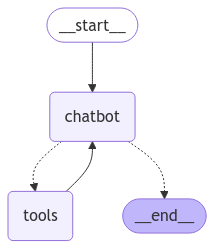

In [9]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [10]:
# The config is the **second position argument** to stream() or invoke()!
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [("user", input("User: "))]}, config, stream_mode="values"
)
for event in events:
    event['messages'][-1].pretty_print()

================================ Human Message =================================

대한민국 축구 국가대표팀 명단 알려줘
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_HdOUIWaLUdsefWQvhuVBZMez)
 Call ID: call_HdOUIWaLUdsefWQvhuVBZMez
  Args:
    query: 대한민국 축구 국가대표팀 명단 2024
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://news.zum.com/articles/87857582", "content": "[문화뉴스 이하온 기자] 2023년 12월 28일(목), 2024 afc 카타르 아시안컵에 출전할 대한민국 남자 축구 국가대표팀 최종명단이 발표되었다. 위르겐 클리스만 감독은 인터뷰에서 \"조별리그에서 맞붙을 세 팀에 대한 숙제(분석)는 어느 정도 끝났다."}, {"url": "https://www.kfa.or.kr/national/?act=mu_23", "content": "대한축구협회. kfa live; 국가대표 ... 2024 waff u-23 챔피언십 사우디아라비아 프린스 압둘라 빈 잘라위 스타디움. 남자 u-23 대표팀 1 ; 태국 0 ; 03. 21 목요일 02:00. 남자u-23 '정승배 멀티골' u-21 선발팀, 인도네시아에 2-1 승리"}, {"url": "https://www.kfa.or.kr/national/?act=nt_man", "content": "남자 국가대표팀 3 ; 쿠웨이트 1 ; 11. 14 목요일 23:00. 2026 f

In [11]:
# imporve controllability using custom tool setting
from dotenv import load_dotenv
load_dotenv()

False

In [12]:
from langchain_core.tools import tool
from tavily import TavilyClient

@tool
def search_news(keyword: str) -> str:
    """Collect recent news for the given query."""
    tavily_client = TavilyClient(api_key=TAVILY_API_KEY)
    search_results = tavily_client.search(query=keyword, topic="news", days=30)
    return search_results

In [16]:
tavily_client = TavilyClient(api_key=TAVILY_API_KEY)
help(tavily_client)

Help on TavilyClient in module tavily.tavily object:

class TavilyClient(builtins.object)
 |  TavilyClient(api_key: Optional[str] = None)
 |  
 |  Tavily API client class.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, api_key: Optional[str] = None)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  extract(self, urls: Union[List[str], str], **kwargs) -> dict
 |      Combined extract method.
 |  
 |  get_company_info(self, query: str, search_depth: Literal['basic', 'advanced'] = 'advanced', max_results: int = 5) -> Sequence[dict]
 |      Company information search method. Search depth is advanced by default to get the best answer.
 |  
 |  get_search_context(self, query: str, search_depth: Literal['basic', 'advanced'] = 'basic', topic: Literal['general', 'news'] = 'general', days: int = 3, max_results: int = 5, include_domains: Sequence[str] = None, exclude_domains: Sequence[str] = None, max_tokens: int = 4000, **kwargs) -> str
 |      Get the searc

In [13]:
# Set prompt while initialize LLM
llm = ChatOpenAI(
    model='gpt-4o-mini',
    temperature=0
)
tools = [search_news]
llm_with_tools = llm.bind_tools(tools)

In [14]:
class State(TypedDict):
    messages: Annotated[list, add_messages]
    
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)

# add a tool node
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

# add a conditional edge
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition
)

# add a edge for returning to the chatbot after tool calling
graph_builder.add_edge("tools", "chatbot")

# set initial point
graph_builder.add_edge(START, "chatbot")

# compile the graph
graph = graph_builder.compile()

In [15]:
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", input("User: "))]}, config, stream_mode="values"
)
for event in events:
    event['messages'][-1].pretty_print()

================================ Human Message =================================

지금 상영하고 있는 영화중 인기가 가장 많은 것은?
================================== Ai Message ==================================
Tool Calls:
  search_news (call_3XUDTklKYtQm9iDpVcmmnhh0)
 Call ID: call_3XUDTklKYtQm9iDpVcmmnhh0
  Args:
    keyword: 현재 상영 중인 인기 영화
================================= Tool Message =================================
Name: search_news

{"query": "현재 상영 중인 인기 영화", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.houstonchronicle.com/entertainment/movies_tv/article/y2k-the-order-new-films-19954939.php", "title": "'Flow,' 'The Order,' 'Y2K,' 'The Return' top the list of new films opening this week - Houston Chronicle", "score": 0.43146437, "published_date": "Wed, 04 Dec 2024 12:11:36 GMT", "content": "'Flow,' 'The Order,' 'Y2K,' 'The Return' top the new films opening 'Flow,' 'The Order,' 'Y2K,' 'The Return' top the list of new films opening this week Opens Fri